FINDING THE PATH

In [1]:
#find path
!ls '/content/drive/MyDrive/WESAD.zip'

/content/drive/MyDrive/WESAD.zip


EXTRACT THE DATA FROM ZIP FILE

In [2]:
# extracting the data and storing it in temprory storage of colab
import zipfile
import os

# Define the path to your zip file
zip_file_path = '/content/drive/MyDrive/WESAD.zip' #path from where you want to extract the data
extract_path = '/content/WESAD/'  # Path where you want to extract files

# Create the directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Unzip the file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete!")

Extraction complete!


Certainly! Here’s an explanation of the code in a step-by-step flow of control:

1. **Define the List of Subject File Paths**:
   - We start by creating a list of file paths for each subject’s data, which are `.pkl` files containing the WESAD dataset for individual subjects. Each path corresponds to a separate subject.

2. **Initialize Storage Lists**:
   - `all_data` and `all_labels` lists are created to store processed sensor data and corresponding labels from each subject.

3. **Initialize Label Encoder**:
   - `LabelEncoder` is initialized to convert categorical labels into numerical values later.

4. **Loop Through Each Subject’s Data File**:
   - For each subject’s file in `subject_files`, the following steps are performed.

5. **Load the Subject Data**:
   - Each `.pkl` file is loaded into a DataFrame called `subject_data`.

6. **Access Wrist Signal Data**:
   - The code extracts wrist signal data from the dataset and stores it in `signal_data`.

7. **Extract Specific Wrist Signals (BVP, EDA, TEMP)**:
   - BVP (Blood Volume Pulse), EDA (Electrodermal Activity), and TEMP (Temperature) signals are extracted and stored in a dictionary called `body_data`.

8. **Determine Minimum Length for Consistent Downsampling**:
   - The minimum length among the BVP, EDA, and TEMP signals is calculated. This ensures each signal has the same length before downsampling.

9. **Truncate Each Signal to Minimum Length**:
   - Each signal (BVP, EDA, and TEMP) is truncated to the minimum length to ensure consistency across all signals.

10. **Set Downsampling Factor**:
   - A downsampling factor (5 in this case) is defined, controlling the number of data points to combine in each downsampling step.

11. **Downsample and Calculate Statistics**:
    - For each signal (BVP, EDA, and TEMP):
      - The signal is reshaped to groups based on the `downsampling_factor`.
      - **Mean**, **Standard Deviation (std)**, and **Maximum (max)** are calculated across each downsampled segment.
      - These statistics (`mean`, `std`, `max`) are added to `body_data`, replacing the original signals.

12. **Convert Processed Data to a DataFrame**:
    - The downsampled and processed data in `body_data` is converted to a DataFrame called `body_df`.

13. **Normalize the Data**:
    - The `MinMaxScaler` scales the data in `body_df` to a range between 0 and 1, and the normalized data is stored in `normalized_df`.

14. **Append Normalized Data to `all_data` List**:
    - The normalized DataFrame (`normalized_df`) is added to the `all_data` list for later concatenation.

15. **Extract and Append Labels**:
    - Labels from each subject are extracted, flattened, and appended to `all_labels`.

16. **Combine All Subjects’ Data and Labels**:
    - After processing all subjects, data in `all_data` is combined into a single DataFrame called `combined_data`.
    - Similarly, all labels in `all_labels` are concatenated into a single array called `combined_labels`.

17. **Convert Multi-Level Labels to Binary Labels**:
    - Labels are converted to binary values where all occurrences of label `2` are relabeled as `1` for binary classification.

18. **Adjust Label Array to Match Data Length**:
    - If the length of `combined_labels` is greater than `combined_data`, labels are downsampled using majority voting (`mode`).
    - This ensures the label array matches the length of the data array.
    - If the labels are shorter than the data, a warning is printed.

19. **Encode Labels**:
    - Labels are encoded as `0` and `1` using `LabelEncoder` for binary classification.

20. **Print Summary of Data and Labels**:
    - The shapes of `combined_data` and `encoded_labels` are printed, along with a sample of the labels and label distribution, to confirm that the data processing is complete.

This step-by-step process ensures that the wrist data is uniformly processed, downsampled, normalized, and encoded for use in a CNN model tailored for stress detection.

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import pandas as pd
from scipy.stats import mode

# List of subject file paths
subject_files = [
    '/content/WESAD/WESAD/S2/S2.pkl',
    '/content/WESAD/WESAD/S3/S3.pkl',
    '/content/WESAD/WESAD/S4/S4.pkl',
    '/content/WESAD/WESAD/S5/S5.pkl',
    '/content/WESAD/WESAD/S6/S6.pkl',
    '/content/WESAD/WESAD/S7/S7.pkl',
    '/content/WESAD/WESAD/S8/S8.pkl',
    '/content/WESAD/WESAD/S9/S9.pkl',
    '/content/WESAD/WESAD/S10/S10.pkl',
    '/content/WESAD/WESAD/S11/S11.pkl',
    '/content/WESAD/WESAD/S13/S13.pkl',
    '/content/WESAD/WESAD/S14/S14.pkl',
    '/content/WESAD/WESAD/S15/S15.pkl',
    '/content/WESAD/WESAD/S16/S16.pkl',
    '/content/WESAD/WESAD/S17/S17.pkl'
]

# Initialize empty lists to store data and labels
all_data = []
all_labels = []

# Initialize LabelEncoder for labels
label_encoder = LabelEncoder()

# Process each subject's data
for file_path in subject_files:
    # Load data for each subject
    subject_data = pd.read_pickle(file_path)

    # Access wrist signal data
    signal_data = subject_data['signal']['wrist']

    # Extract wrist signals (BVP, EDA, TEMP)
    body_data = {
        'bvp': signal_data['BVP'].flatten(),
        'eda': signal_data['EDA'].flatten(),
        'temperature': signal_data['TEMP'].flatten()
    }

    # Determine the minimum length of the signals for consistent downsampling
    min_length = min(len(body_data['bvp']), len(body_data['eda']), len(body_data['temperature']))

    # Truncate each signal to the minimum length
    for signal in ['bvp', 'eda', 'temperature']:
        body_data[signal] = body_data[signal][:min_length]

    # Define downsampling factor (e.g., 5)
    downsampling_factor = 5  # Adjust this as needed for balancing detail and processing

    # Downsample and calculate statistics (mean, std, max) for each signal
    for signal in ['bvp', 'eda', 'temperature']:
        signal_values = body_data[signal]
        downsampled_length = min_length // downsampling_factor

        # Reshape for downsampling (this should prevent zeros in std calculation)
        reshaped_signal = signal_values[:downsampled_length * downsampling_factor].reshape(-1, downsampling_factor)

        # Calculate mean, std, and max across each downsampled segment
        mean_values = np.mean(reshaped_signal, axis=1)
        std_values = np.std(reshaped_signal, axis=1)
        max_values = np.max(reshaped_signal, axis=1)

        # Add the calculated statistics to the data dictionary
        body_data[f'{signal}_mean'] = mean_values
        body_data[f'{signal}_std'] = std_values
        body_data[f'{signal}_max'] = max_values

        # Remove original signal data to avoid redundancy
        del body_data[signal]

    # Convert processed data into a DataFrame
    body_df = pd.DataFrame(body_data)

    # Normalize the sensor data
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(body_df)
    normalized_df = pd.DataFrame(normalized_data, columns=body_df.columns)

    # Append normalized data
    all_data.append(normalized_df)

    # Extract and append labels for each subject
    labels = subject_data['label'].flatten()
    all_labels.append(labels)

# Combine data and labels across all subjects
combined_data = pd.concat(all_data, ignore_index=True)
combined_labels = np.concatenate(all_labels)

# Convert multi-level labels (e.g., stress levels) to binary classification if needed
combined_labels = np.where(combined_labels == 2, 1, combined_labels)

# Adjust label array to match combined data length
desired_length = len(combined_data)
if len(combined_labels) > desired_length:
    # Downsample combined_labels using mode (majority voting)
    ratio = len(combined_labels) // desired_length
    combined_labels = [
        mode(combined_labels[min(i * ratio, len(combined_labels) - 1):min((i + 1) * ratio, len(combined_labels))]).mode[0]
        if len(combined_labels[min(i * ratio, len(combined_labels) - 1):min((i + 1) * ratio, len(combined_labels))]) > 0 and isinstance(mode(combined_labels[min(i * ratio, len(combined_labels) - 1):min((i + 1) * ratio, len(combined_labels))]).mode, np.ndarray)
        else combined_labels[min(i * ratio, len(combined_labels) - 1)]
        for i in range(desired_length)
    ]
elif len(combined_labels) < desired_length:
    print("Warning: The number of combined labels is less than the number of combined data rows.")

# Check processed data shapes and distributions
print("Combined Data Shape:", combined_data.shape)
print("Encoded Labels Shape:", encoded_labels.shape)
print("Encoded Labels Sample:", encoded_labels[:10])
print("New Label Distribution:", {i: np.sum(encoded_labels == i) for i in np.unique(encoded_labels)})


Combined Data Shape: (69487, 9)
Encoded Labels Shape: (69487,)
Encoded Labels Sample: [0 0 0 0 0 0 0 0 0 0]
New Label Distribution: {0: 31598, 1: 22060, 2: 4464, 3: 9444, 4: 633, 5: 632, 6: 656}


Checking for duplicate rows and basic statistics

In [4]:
import pandas as pd

# Assuming combined_data is your DataFrame
# Check for duplicates
duplicate_rows = combined_data[combined_data.duplicated()]
num_duplicates = duplicate_rows.shape[0]

# Check for null values
null_values = combined_data.isnull().sum()
total_nulls = null_values[null_values > 0]

# Get basic statistics
statistics = combined_data.describe()

# Print results
print("Number of Duplicate Rows:", num_duplicates)
if num_duplicates > 0:
    print("\nDuplicate Rows:\n", duplicate_rows)

print("\nTotal Null Values in Each Column:\n", total_nulls)

print("\nBasic Statistics:\n", statistics)


Number of Duplicate Rows: 0

Total Null Values in Each Column:
 Series([], dtype: int64)

Basic Statistics:
            bvp_mean       bvp_std       bvp_max      eda_mean       eda_std  \
count  69487.000000  69487.000000  69487.000000  69487.000000  69487.000000   
mean       0.521660      0.055586      0.496505      0.235844      0.023337   
std        0.099959      0.077850      0.096481      0.231481      0.057822   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.458773      0.011517      0.431044      0.066755      0.004030   
50%        0.516266      0.028862      0.498660      0.159124      0.007525   
75%        0.586911      0.067154      0.560425      0.310885      0.016826   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

            eda_max  temperature_mean  temperature_std  temperature_max  
count  69487.000000      69487.000000     69487.000000     69487.000000  
mean       0.227349          0.

Viewing combined data once

In [5]:
import pandas as pd

# Assuming combined_data is your DataFrame
# Display the first 5 rows of the DataFrame
print("First 5 Rows of Combined Data:")
print(combined_data.head())

# Display the structure of the DataFrame
print("\nDataFrame Structure:")
print(combined_data.info())

# Optionally, you can display summary statistics for numerical columns
print("\nSummary Statistics:")
print(combined_data.describe())



First 5 Rows of Combined Data:
   bvp_mean   bvp_std   bvp_max  eda_mean   eda_std   eda_max  \
0  0.432751  0.081647  0.403546  0.611997  0.150707  0.649919   
1  0.483221  0.080188  0.452608  0.568807  0.118939  0.623526   
2  0.509877  0.018219  0.466198  0.736725  0.089108  0.746674   
3  0.511898  0.001696  0.465986  0.748934  0.052465  0.750546   
4  0.511151  0.001481  0.465021  0.693120  0.036978  0.692458   

   temperature_mean  temperature_std  temperature_max  
0          0.848684            0.000         0.846154  
1          0.848684            0.000         0.846154  
2          0.848684            0.000         0.846154  
3          0.853070            0.125         0.851648  
4          0.849781            0.125         0.851648  

DataFrame Structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69487 entries, 0 to 69486
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bvp_mean     

Viewing one of the pkl files for checking number of lables in dataset

viewing unique lables in .pkl file

In [6]:
import pandas as pd

# Load the S2.pkl file
file_path = '/content/WESAD/WESAD/S2/S2.pkl'
subject_data = pd.read_pickle(file_path)

# Access the labels
labels = subject_data['label']

# Get unique values of the labels
unique_labels = pd.unique(labels)

# Display the unique labels
print("Unique Labels in S2.pkl:", unique_labels)


Unique Labels in S2.pkl: [0 1 2 6 4 3 7]


combining the lables 1 - 7 as single lable 1 so that we can balance the classes of unstressed and stressed. Because Unstressed class have lot of data compared to each labled stress class. And we have to perform binary classification, so two lables 0 and 1 are needed.

In [7]:
import numpy as np
import pandas as pd

# Sample labels array for demonstration; replace this with your actual labels array
# combined_labels = np.array([...])  # Assuming you already have the combined labels in a NumPy array

# If your labels are in a DataFrame, you can use:
# combined_labels = your_dataframe['your_label_column'].to_numpy()

# Combine labels 1 to 7 into a single class labeled as 1
combined_labels = np.where(np.isin(combined_labels, [1, 2, 3, 4, 5, 6, 7]), 1, combined_labels)

# Verify the changes
new_label_distribution = {i: np.sum(combined_labels == i) for i in np.unique(combined_labels)}

# Output the new label distribution
print("New Label Distribution:", new_label_distribution)


New Label Distribution: {0: 31598, 1: 37889}


In [8]:
import pandas as pd

# Assuming combined_data contains the features and encoded_labels contains the new labels
# combined_data should be a DataFrame containing columns for BVP, EDA, and Temperature

# Ensure both combined_data and encoded_labels are the same length
assert len(combined_data) == len(encoded_labels), "Data and labels must be of the same length"

# Combine the processed data and the labels into a single DataFrame
# Assuming combined_data is your existing DataFrame that contains the processed features
combined_df = pd.DataFrame(combined_data)  # Use combined_data directly
combined_df['Labels'] = encoded_labels  # Add the new labels as a column

# Check the combined DataFrame
print("Combined DataFrame Preview:\n", combined_df.head())
print("Shape of Combined DataFrame:", combined_df.shape)

# Check for missing values
missing_values = combined_df.isnull().sum()
print("Missing Values in Each Column:\n", missing_values)

# Check the distribution of labels to ensure synchronization
label_distribution = combined_df['Labels'].value_counts()
print("Label Distribution:\n", label_distribution)


Combined DataFrame Preview:
    bvp_mean   bvp_std   bvp_max  eda_mean   eda_std   eda_max  \
0  0.432751  0.081647  0.403546  0.611997  0.150707  0.649919   
1  0.483221  0.080188  0.452608  0.568807  0.118939  0.623526   
2  0.509877  0.018219  0.466198  0.736725  0.089108  0.746674   
3  0.511898  0.001696  0.465986  0.748934  0.052465  0.750546   
4  0.511151  0.001481  0.465021  0.693120  0.036978  0.692458   

   temperature_mean  temperature_std  temperature_max  Labels  
0          0.848684            0.000         0.846154       0  
1          0.848684            0.000         0.846154       0  
2          0.848684            0.000         0.846154       0  
3          0.853070            0.125         0.851648       0  
4          0.849781            0.125         0.851648       0  
Shape of Combined DataFrame: (69487, 10)
Missing Values in Each Column:
 bvp_mean            0
bvp_std             0
bvp_max             0
eda_mean            0
eda_std             0
eda_max      

**Checking data Quality**

In [9]:
# Check for missing values
missing_values = combined_df.isnull().sum()
print("Missing Values in Each Column:\n", missing_values)

# Check data types of each column
data_types = combined_df.dtypes
print("\nData Types in Combined DataFrame:\n", data_types)

# Get summary statistics for the numeric columns
summary_statistics = combined_df.describe()
print("\nSummary Statistics:\n", summary_statistics)

# Check for duplicate rows
duplicate_rows = combined_df.duplicated().sum()
print("\nNumber of Duplicate Rows:", duplicate_rows)

# Check label distribution
label_distribution = combined_df['Labels'].value_counts()
print("\nLabel Distribution:\n", label_distribution)

# Additional quality checks (optional)
# Check for outliers using Interquartile Range (IQR)
# Adjust the columns as per your current DataFrame
# Replace with your actual numeric column names from combined_df
numeric_columns = ['bvp_mean', 'bvp_std', 'eda_mean']  # Example: Replace with your actual column names
Q1 = combined_df[numeric_columns].quantile(0.25)
Q3 = combined_df[numeric_columns].quantile(0.75)
IQR = Q3 - Q1
outlier_condition = ((combined_df[numeric_columns] < (Q1 - 1.5 * IQR)) | (combined_df[numeric_columns] > (Q3 + 1.5 * IQR)))
outliers = outlier_condition.sum()
print("\nOutliers in Each Column:\n", outliers)

# Optional: Check for any specific value counts for BVP, EDA, and Temperature
for col in numeric_columns:
    value_counts = combined_df[col].value_counts()
    print(f"\nValue Counts for {col}:\n", value_counts)

Missing Values in Each Column:
 bvp_mean            0
bvp_std             0
bvp_max             0
eda_mean            0
eda_std             0
eda_max             0
temperature_mean    0
temperature_std     0
temperature_max     0
Labels              0
dtype: int64

Data Types in Combined DataFrame:
 bvp_mean            float64
bvp_std             float64
bvp_max             float64
eda_mean            float64
eda_std             float64
eda_max             float64
temperature_mean    float64
temperature_std     float64
temperature_max     float64
Labels                int64
dtype: object

Summary Statistics:
            bvp_mean       bvp_std       bvp_max      eda_mean       eda_std  \
count  69487.000000  69487.000000  69487.000000  69487.000000  69487.000000   
mean       0.521660      0.055586      0.496505      0.235844      0.023337   
std        0.099959      0.077850      0.096481      0.231481      0.057822   
min        0.000000      0.000000      0.000000      0.000000      

In [10]:
# Remove duplicate rows from the combined DataFrame
combined_df = combined_df.drop_duplicates()

# Check the shape of the DataFrame after removing duplicates
print("Shape of combined DataFrame after removing duplicates:", combined_df.shape)

# Preview the updated DataFrame
print("Combined DataFrame Preview:")
print(combined_df.head())


Shape of combined DataFrame after removing duplicates: (69487, 10)
Combined DataFrame Preview:
   bvp_mean   bvp_std   bvp_max  eda_mean   eda_std   eda_max  \
0  0.432751  0.081647  0.403546  0.611997  0.150707  0.649919   
1  0.483221  0.080188  0.452608  0.568807  0.118939  0.623526   
2  0.509877  0.018219  0.466198  0.736725  0.089108  0.746674   
3  0.511898  0.001696  0.465986  0.748934  0.052465  0.750546   
4  0.511151  0.001481  0.465021  0.693120  0.036978  0.692458   

   temperature_mean  temperature_std  temperature_max  Labels  
0          0.848684            0.000         0.846154       0  
1          0.848684            0.000         0.846154       0  
2          0.848684            0.000         0.846154       0  
3          0.853070            0.125         0.851648       0  
4          0.849781            0.125         0.851648       0  


box plot to check outliners


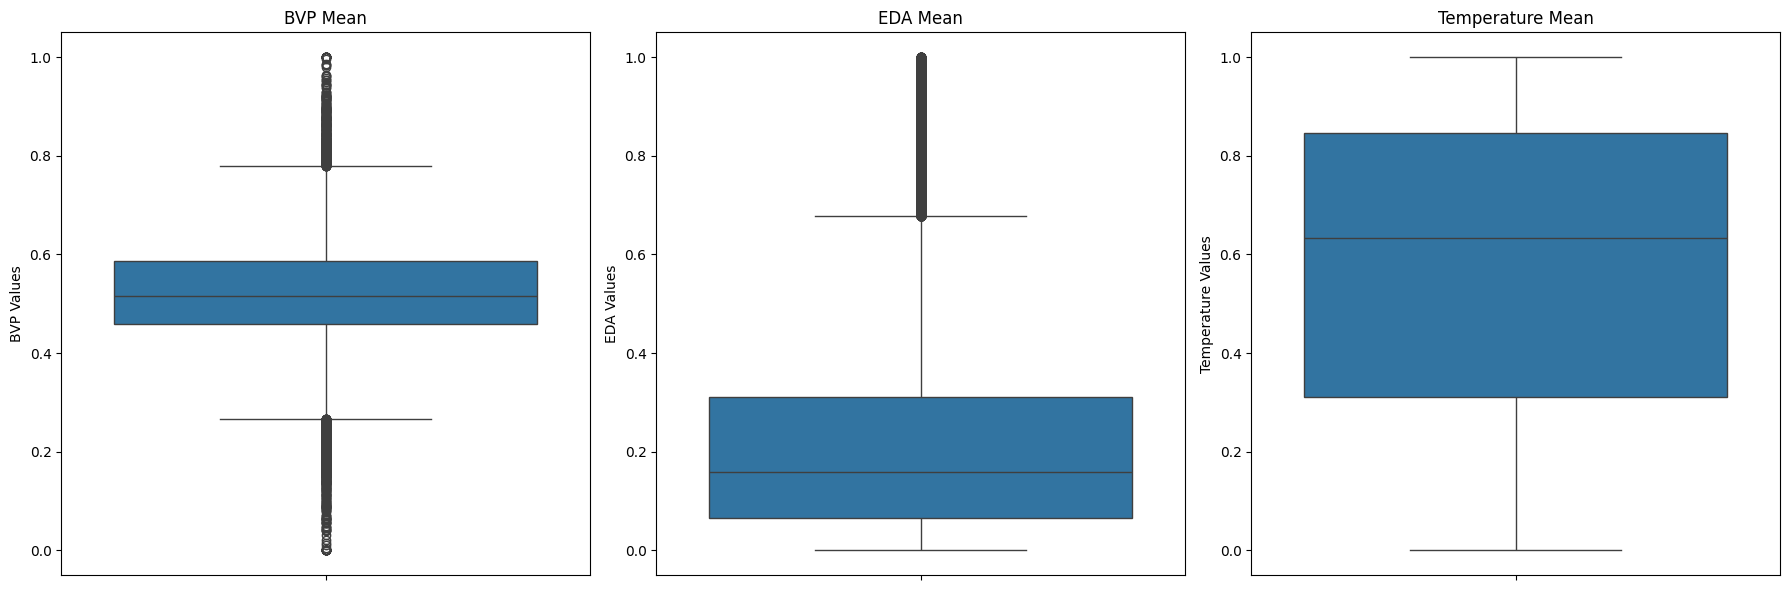

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create box plots for each sensor
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.boxplot(y=combined_df['bvp_mean'])
plt.title('BVP Mean')
plt.ylabel('BVP Values')

plt.subplot(1, 3, 2)
sns.boxplot(y=combined_df['eda_mean'])
plt.title('EDA Mean')
plt.ylabel('EDA Values')

plt.subplot(1, 3, 3)
sns.boxplot(y=combined_df['temperature_mean'])
plt.title('Temperature Mean')
plt.ylabel('Temperature Values')

plt.tight_layout()
plt.show()


In [12]:
# Display the column names in combined_df
print(combined_df.columns)


Index(['bvp_mean', 'bvp_std', 'bvp_max', 'eda_mean', 'eda_std', 'eda_max',
       'temperature_mean', 'temperature_std', 'temperature_max', 'Labels'],
      dtype='object')


In [13]:
# Relabel 1 to 5 as 1 in the 'Labels' column
combined_df['Labels'] = combined_df['Labels'].replace([1, 2, 3, 4, 5, 6], 1)

# Check the updated combined_df
print("Updated Combined DataFrame Preview:\n", combined_df.head())

# Check the new label distribution to verify the changes
new_label_distribution = combined_df['Labels'].value_counts()
print("New Label Distribution:\n", new_label_distribution)

# Check for unique labels and their counts in the 'Labels' column
unique_labels_counts = combined_df['Labels'].value_counts()

# Display the unique labels and their counts
print("Unique Labels and Their Counts:\n", unique_labels_counts)


Updated Combined DataFrame Preview:
    bvp_mean   bvp_std   bvp_max  eda_mean   eda_std   eda_max  \
0  0.432751  0.081647  0.403546  0.611997  0.150707  0.649919   
1  0.483221  0.080188  0.452608  0.568807  0.118939  0.623526   
2  0.509877  0.018219  0.466198  0.736725  0.089108  0.746674   
3  0.511898  0.001696  0.465986  0.748934  0.052465  0.750546   
4  0.511151  0.001481  0.465021  0.693120  0.036978  0.692458   

   temperature_mean  temperature_std  temperature_max  Labels  
0          0.848684            0.000         0.846154       0  
1          0.848684            0.000         0.846154       0  
2          0.848684            0.000         0.846154       0  
3          0.853070            0.125         0.851648       0  
4          0.849781            0.125         0.851648       0  
New Label Distribution:
 Labels
1    37889
0    31598
Name: count, dtype: int64
Unique Labels and Their Counts:
 Labels
1    37889
0    31598
Name: count, dtype: int64


Handeling the Outliners
Step 1 - find lower and  higher whisker


Code to Handle Outliers by Capping and Adding Variation

In [14]:
import pandas as pd
import numpy as np

# Assuming combined_df is your DataFrame
# Step 1: Calculate Q1, Q3, and IQR for each relevant column
Q1 = combined_df[['bvp_mean', 'bvp_std', 'bvp_max', 'eda_mean', 'eda_std', 'eda_max', 'temperature_mean', 'temperature_std', 'temperature_max']].quantile(0.25)
Q3 = combined_df[['bvp_mean', 'bvp_std', 'bvp_max', 'eda_mean', 'eda_std', 'eda_max', 'temperature_mean', 'temperature_std', 'temperature_max']].quantile(0.75)
IQR = Q3 - Q1

# Step 2: Define bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Step 3: Cap outliers and add variation
def cap_outliers(series, lower, upper):
    # Cap lower outliers
    series = np.where(series < lower, lower + np.random.uniform(0, 0.1 * (upper - lower), size=series.shape), series)
    # Cap upper outliers
    series = np.where(series > upper, upper - np.random.uniform(0, 0.1 * (upper - lower), size=series.shape), series)
    return series

# Apply the function to each relevant column
for column in ['bvp_mean', 'bvp_std', 'bvp_max', 'eda_mean', 'eda_std', 'eda_max', 'temperature_mean', 'temperature_std', 'temperature_max']:
    combined_df[column] = cap_outliers(combined_df[column].values, lower_bound[column], upper_bound[column])

# Check the modified DataFrame for outliers
print("Outlier values have been capped and modified.")


Outlier values have been capped and modified.


Checking for outliners

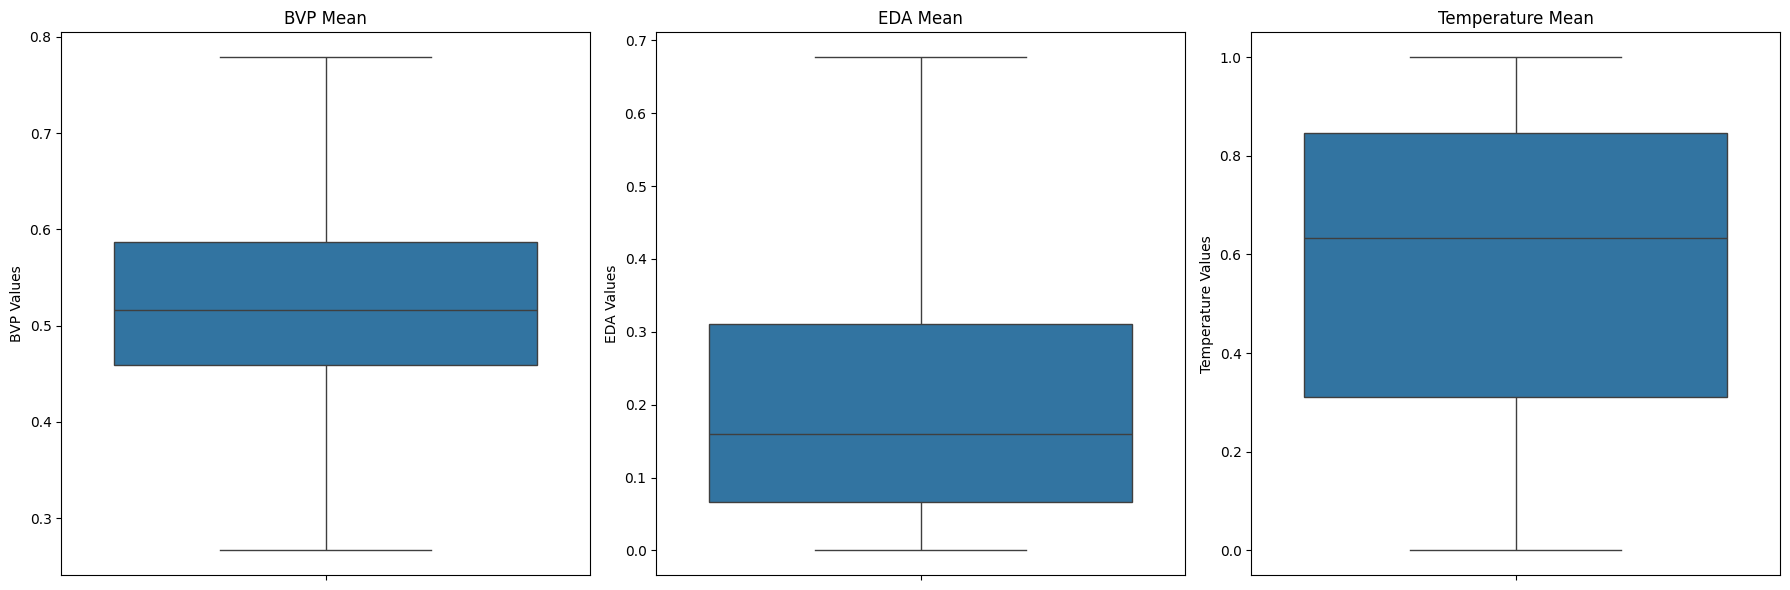

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create box plots for each sensor
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.boxplot(y=combined_df['bvp_mean'])
plt.title('BVP Mean')
plt.ylabel('BVP Values')

plt.subplot(1, 3, 2)
sns.boxplot(y=combined_df['eda_mean'])
plt.title('EDA Mean')
plt.ylabel('EDA Values')

plt.subplot(1, 3, 3)
sns.boxplot(y=combined_df['temperature_mean'])
plt.title('Temperature Mean')
plt.ylabel('Temperature Values')

plt.tight_layout()
plt.show()


checking for outliners

In [16]:
import pandas as pd

# Calculate the first and third quartiles (Q1 and Q3)
Q1 = combined_df[['bvp_mean', 'bvp_std', 'bvp_max', 'eda_mean', 'eda_std', 'eda_max', 'temperature_mean', 'temperature_std', 'temperature_max']].quantile(0.25)
Q3 = combined_df[['bvp_mean', 'bvp_std', 'bvp_max', 'eda_mean', 'eda_std', 'eda_max', 'temperature_mean', 'temperature_std', 'temperature_max']].quantile(0.75)

# Calculate the IQR
IQR = Q3 - Q1

# Define the lower and upper whiskers
lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR

# Identify outliers
outliers = combined_df[
    (combined_df[['bvp_mean', 'bvp_std', 'bvp_max', 'eda_mean', 'eda_std', 'eda_max', 'temperature_mean', 'temperature_std', 'temperature_max']] < lower_whisker) |
    (combined_df[['bvp_mean', 'bvp_std', 'bvp_max', 'eda_mean', 'eda_std', 'eda_max', 'temperature_mean', 'temperature_std', 'temperature_max']] > upper_whisker)
]

# Display the outliers
print("Outliers detected in the data:")
print(outliers)
combined_df.head()


Outliers detected in the data:
       bvp_mean  bvp_std  bvp_max  eda_mean  eda_std  eda_max  \
0           NaN      NaN      NaN       NaN      NaN      NaN   
1           NaN      NaN      NaN       NaN      NaN      NaN   
2           NaN      NaN      NaN       NaN      NaN      NaN   
3           NaN      NaN      NaN       NaN      NaN      NaN   
4           NaN      NaN      NaN       NaN      NaN      NaN   
...         ...      ...      ...       ...      ...      ...   
69482       NaN      NaN      NaN       NaN      NaN      NaN   
69483       NaN      NaN      NaN       NaN      NaN      NaN   
69484       NaN      NaN      NaN       NaN      NaN      NaN   
69485       NaN      NaN      NaN       NaN      NaN      NaN   
69486       NaN      NaN      NaN       NaN      NaN      NaN   

       temperature_mean  temperature_std  temperature_max  Labels  
0                   NaN              NaN              NaN     NaN  
1                   NaN              NaN            

,bvp_mean,bvp_std,bvp_max,eda_mean,eda_std,eda_max,temperature_mean,temperature_std,temperature_max,Labels
0,0.432751,0.081647,0.403546,0.611997,0.035060,0.649919,0.848684,0.000,0.846154,0
1,0.483221,0.080188,0.452608,0.568807,0.035094,0.623526,0.848684,0.000,0.846154,0
2,0.509877,0.018219,0.466198,0.629618,0.034659,0.601749,0.848684,0.000,0.846154,0
3,0.511898,0.001696,0.465986,0.630495,0.033288,0.595626,0.853070,0.125,0.851648,0
4,0.511151,0.001481,0.465021,0.605312,0.034211,0.638406,0.849781,0.125,0.851648,0


Check the data

In [17]:
import pandas as pd

# Check for missing values
missing_values = combined_df.isnull().sum()
print("Missing Values in Each Column:\n", missing_values)

# Check data types of each column
data_types = combined_df.dtypes
print("\nData Types in Combined DataFrame:\n", data_types)

# Get summary statistics for the numeric columns
summary_statistics = combined_df.describe()
print("\nSummary Statistics:\n", summary_statistics)

# Check for duplicate rows
duplicate_rows = combined_df.duplicated().sum()
print("\nNumber of Duplicate Rows:", duplicate_rows)

# Check label distribution
label_distribution = combined_df['Labels'].value_counts()
print("\nLabel Distribution:\n", label_distribution)

# Check for outliers using Interquartile Range (IQR) for relevant columns
Q1 = combined_df[['bvp_mean', 'bvp_std', 'bvp_max', 'eda_mean', 'eda_std', 'eda_max',
                  'temperature_mean', 'temperature_std', 'temperature_max']].quantile(0.25)
Q3 = combined_df[['bvp_mean', 'bvp_std', 'bvp_max', 'eda_mean', 'eda_std', 'eda_max',
                  'temperature_mean', 'temperature_std', 'temperature_max']].quantile(0.75)
IQR = Q3 - Q1

# Determine outliers based on the IQR
outlier_condition = ((combined_df[['bvp_mean', 'bvp_std', 'bvp_max', 'eda_mean',
                                     'eda_std', 'eda_max', 'temperature_mean',
                                     'temperature_std', 'temperature_max']] < (Q1 - 1.5 * IQR)) |
                     (combined_df[['bvp_mean', 'bvp_std', 'bvp_max', 'eda_mean',
                                     'eda_std', 'eda_max', 'temperature_mean',
                                     'temperature_std', 'temperature_max']] > (Q3 + 1.5 * IQR)))

outliers = outlier_condition.sum()
print("\nOutliers in Each Column:\n", outliers)


Missing Values in Each Column:
 bvp_mean            0
bvp_std             0
bvp_max             0
eda_mean            0
eda_std             0
eda_max             0
temperature_mean    0
temperature_std     0
temperature_max     0
Labels              0
dtype: int64

Data Types in Combined DataFrame:
 bvp_mean            float64
bvp_std             float64
bvp_max             float64
eda_mean            float64
eda_std             float64
eda_max             float64
temperature_mean    float64
temperature_std     float64
temperature_max     float64
Labels                int64
dtype: object

Summary Statistics:
            bvp_mean       bvp_std       bvp_max      eda_mean       eda_std  \
count  69487.000000  69487.000000  69487.000000  69487.000000  69487.000000   
mean       0.522082      0.045741      0.496342      0.221722      0.012041   
std        0.095384      0.043696      0.091906      0.198131      0.010766   
min        0.266577      0.000000      0.236982      0.000000      

In [18]:
import pandas as pd

# Check for missing values
missing_values = combined_df.isnull().sum()
print("Missing Values in Each Column:\n", missing_values)

# Check data types of each column
data_types = combined_df.dtypes
print("\nData Types in Combined DataFrame:\n", data_types)

# Get summary statistics for the numeric columns
summary_statistics = combined_df.describe()
print("\nSummary Statistics:\n", summary_statistics)

# Check for duplicate rows
duplicate_rows = combined_df.duplicated().sum()
print("\nNumber of Duplicate Rows:", duplicate_rows)

# Check label distribution
label_distribution = combined_df['Labels'].value_counts()
print("\nLabel Distribution:\n", label_distribution)

# Check for outliers using Interquartile Range (IQR)
Q1 = combined_df[['bvp_mean', 'bvp_std', 'bvp_max', 'eda_mean', 'eda_std', 'eda_max',
                  'temperature_mean', 'temperature_std', 'temperature_max']].quantile(0.25)
Q3 = combined_df[['bvp_mean', 'bvp_std', 'bvp_max', 'eda_mean', 'eda_std', 'eda_max',
                  'temperature_mean', 'temperature_std', 'temperature_max']].quantile(0.75)
IQR = Q3 - Q1

outlier_condition = ((combined_df[['bvp_mean', 'bvp_std', 'bvp_max', 'eda_mean', 'eda_std', 'eda_max',
                                     'temperature_mean', 'temperature_std', 'temperature_max']] < (Q1 - 1.5 * IQR)) |
                     (combined_df[['bvp_mean', 'bvp_std', 'bvp_max', 'eda_mean', 'eda_std', 'eda_max',
                                     'temperature_mean', 'temperature_std', 'temperature_max']] > (Q3 + 1.5 * IQR)))
outliers = outlier_condition.sum()
print("\nOutliers in Each Column:\n", outliers)

# Check correlations among features
correlation_matrix = combined_df.corr()
print("\nCorrelation Matrix:\n", correlation_matrix)



Missing Values in Each Column:
 bvp_mean            0
bvp_std             0
bvp_max             0
eda_mean            0
eda_std             0
eda_max             0
temperature_mean    0
temperature_std     0
temperature_max     0
Labels              0
dtype: int64

Data Types in Combined DataFrame:
 bvp_mean            float64
bvp_std             float64
bvp_max             float64
eda_mean            float64
eda_std             float64
eda_max             float64
temperature_mean    float64
temperature_std     float64
temperature_max     float64
Labels                int64
dtype: object

Summary Statistics:
            bvp_mean       bvp_std       bvp_max      eda_mean       eda_std  \
count  69487.000000  69487.000000  69487.000000  69487.000000  69487.000000   
mean       0.522082      0.045741      0.496342      0.221722      0.012041   
std        0.095384      0.043696      0.091906      0.198131      0.010766   
min        0.266577      0.000000      0.236982      0.000000      

checking if their is much difference between 0 label and 1 label data


In [19]:
import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu

# Load your data
# Assuming your data is in a DataFrame called `data` and `label` is the column with labels 0 and 1
# data = pd.read_csv('your_data.csv')  # Uncomment and load your data here

# List of features to compare
features = ['bvp_mean', 'eda_mean', 'temperature_mean']  # Add all relevant features here

# Separate data by label
label_0_data = combined_df[combined_df['Labels'] == 0]  # Changed 'data' to 'combined_df' and 'label' to 'Labels'
label_1_data = combined_df[combined_df['Labels'] == 1]  # Changed 'data' to 'combined_df' and 'label' to 'Labels'

# Dictionary to store test results
results = {}

for feature in features:
    # Perform t-test (assumes normal distribution)
    t_stat, t_p_value = ttest_ind(label_0_data[feature], label_1_data[feature], equal_var=False)

    # Perform Mann-Whitney U test (non-parametric)
    mw_stat, mw_p_value = mannwhitneyu(label_0_data[feature], label_1_data[feature])

    # Save results for each feature
    results[feature] = {
        't-test p-value': t_p_value,
        'Mann-Whitney U p-value': mw_p_value
    }

# Display results
results_df = pd.DataFrame(results).T
print("Statistical Analysis Results:")
print(results_df)

# Interpretation
for feature in results:
    t_p_value = results[feature]['t-test p-value']
    mw_p_value = results[feature]['Mann-Whitney U p-value']

    print(f"\nFeature: {feature}")
    if t_p_value < 0.05 or mw_p_value < 0.05:
        print(f"   Significant difference between label 0 and label 1 (p-values: t-test={t_p_value:.4f}, Mann-Whitney U={mw_p_value:.4f})")
    else:
        print(f"   No significant difference between label 0 and label 1 (p-values: t-test={t_p_value:.4f}, Mann-Whitney U={mw_p_value:.4f})")


Statistical Analysis Results:
                  t-test p-value  Mann-Whitney U p-value
bvp_mean            7.187652e-01            1.013350e-01
eda_mean            1.253196e-21            4.758661e-87
temperature_mean    0.000000e+00            0.000000e+00

Feature: bvp_mean
   No significant difference between label 0 and label 1 (p-values: t-test=0.7188, Mann-Whitney U=0.1013)

Feature: eda_mean
   Significant difference between label 0 and label 1 (p-values: t-test=0.0000, Mann-Whitney U=0.0000)

Feature: temperature_mean
   Significant difference between label 0 and label 1 (p-values: t-test=0.0000, Mann-Whitney U=0.0000)


MODEL BUILDING AND TRAINING

In [34]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, Dense, GlobalAveragePooling1D, Dropout, concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

def inception_residual_block(input_tensor, filters):
    """
    Inception-Residual block for the model.

    Args:
        input_tensor: Input tensor to the block.
        filters: Number of filters for the convolutional layers.

    Returns:
        Output tensor of the block.
    """
    conv1 = Conv1D(filters, 1, padding='same')(input_tensor)
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)

    conv3 = Conv1D(filters, 3, padding='same')(input_tensor)
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)

    conv5 = Conv1D(filters, 5, padding='same')(input_tensor)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)

    inception_output = concatenate([conv1, conv3, conv5], axis=-1)

    shortcut = Conv1D(filters * 3, 1, padding='same')(input_tensor)
    shortcut = BatchNormalization()(shortcut)

    x = Add()([inception_output, shortcut])
    x = Activation('relu')(x)
    return x


def build_resnet_inception_model(input_shape):
    """
    Builds the ResNet-Inception model.

    Args:
        input_shape: Shape of the input data.

    Returns:
        Compiled Keras model.
    """
    inputs = Input(shape=input_shape)
    x = inputs

    for filters in [32, 64, 128, 32]:
        x = inception_residual_block(x, filters)

    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)  # Binary classification

    model = Model(inputs, outputs)
    return model


def pad_and_reshape(data, timesteps=4):
    """
    Pads and reshapes the input data for the Conv1D layer.

    Args:
        data: Input data to be padded and reshaped.
        timesteps: Desired number of timesteps.

    Returns:
        Padded and reshaped data.
    """
    padding_needed = timesteps - data.shape[1] % timesteps
    if padding_needed != 0:
        padding_shape = (data.shape[0], padding_needed)
        padding = np.zeros(padding_shape)
        data_padded = np.concatenate([data, padding], axis=1)
    else:
        data_padded = data
    return data_padded.reshape(data_padded.shape[0], timesteps, -1)


# Assuming 'combined_df' is your DataFrame
X = combined_df.drop(columns=['Labels']).values
y = combined_df['Labels'].values

# Split data
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_raw, X_val_raw, y_train, y_val = train_test_split(X_train_raw, y_train, test_size=0.2, random_state=42)

# Pad and reshape data (timestep is now 4)
X_train = pad_and_reshape(X_train_raw, timesteps=4)
X_test = pad_and_reshape(X_test_raw, timesteps=4)
X_val = pad_and_reshape(X_val_raw, timesteps=4)

# Build and compile the model
input_shape = X_train.shape[1:]
model = build_resnet_inception_model(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary to confirm changes
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 4, 3)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_48 (Conv1D)        │ (None, 4, 32)          │            128 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_49 (Conv1D)        │ (None, 4, 32)          │            320 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_50 (Conv1D)        │ (None, 4, 32)          │            512 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_48    │ (None, 4, 32)          │            128 │ conv1d_48[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_49    │ (None, 4, 32)          │            128 │ conv1d_49[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_50    │ (None, 4, 32)          │            128 │ conv1d_50[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_48             │ (None, 4, 32)          │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_49             │ (None, 4, 32)          │              0 │ batch_normalization_4… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_50             │ (None, 4, 32)          │              0 │ batch_normalization_5… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_51 (Conv1D)        │ (None, 4, 96)          │            384 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_12            │ (None, 4, 96)          │              0 │ activation_48[0][0],   │
│ (Concatenate)             │                        │                │ activation_49[0][0],   │
│                           │                        │                │ activation_50[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_51    │ (None, 4, 96)          │            384 │ conv1d_51[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_12 (Add)              │ (None, 4, 96)          │              0 │ concatenate_12[0][0],  │
│                           │                        │                │ batch_normalization_5… │
├──────────────────────

 Total params: 545,665 (2.08 MB)

 Trainable params: 542,593 (2.07 MB)

 Non-trainable params: 3,072 (12.00 KB)

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Fit the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

Epoch 1/50
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 45s 25ms/step - accuracy: 0.5688 - loss: 0.6956 - val_accuracy: 0.6096 - val_loss: 0.6508 - learning_rate: 0.0010
Epoch 2/50
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 41s 25ms/step - accuracy: 0.6229 - loss: 0.6477 - val_accuracy: 0.6622 - val_loss: 0.6203 - learning_rate: 0.0010
Epoch 3/50
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 39s 24ms/step - accuracy: 0.6489 - loss: 0.6283 - val_accuracy: 0.6707 - val_loss: 0.6078 - learning_rate: 0.0010
Epoch 4/50
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.6655 - loss: 0.6175 - val_accuracy: 0.6838 - val_loss: 0.6046 - learning_rate: 0.0010
Epoch 5/50
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 41s 24ms/step - accuracy: 0.6781 - loss: 0.6035 - val_accuracy: 0.7020 - val_loss: 0.5733 - learning_rate: 0.0010
Epoch 6/50
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 43s 25ms/step - accuracy: 0.6910 - loss: 0.5867 - val_accuracy: 0.7043 - val_loss: 0.5659 - learning_rate: 0.0010
Epoch 7/50
1390/1390 ━━━━━━━━━━━━━━━━━━━━ 40s 25ms/step - accura

DATA AUGMENTATION

In [26]:
import numpy as np
import pandas as pd

def augment_data(df, noise_levels, num_augmentations=3):
    augmented_data = []

    for index, row in df.iterrows():
        for _ in range(num_augmentations):
            # Copy the original row to create an augmented version
            augmented_row = row.copy()
            for column in noise_levels.keys():
                # Add random noise within the specified range
                noise = np.random.uniform(-noise_levels[column], noise_levels[column])
                augmented_row[column] += noise

                # Ensure the data remains within the specified range
                augmented_row[column] = max(0, augmented_row[column])  # Assuming all values should be >= 0

            augmented_data.append(augmented_row)

    return pd.DataFrame(augmented_data)

# Assuming combined_df is your original DataFrame
noise_levels = {
    'bvp_mean': 0.02,
    'bvp_std': 0.01,
    'bvp_max': 0.01,
    'eda_mean': 0.01,
    'eda_std': 0.005,
    'eda_max': 0.005,
    'temperature_mean': 0.01,
    'temperature_std': 0.01,
    'temperature_max': 0.01,
}

# Generate augmented data with 3 unique augmentations per original data point
augmented_df = augment_data(combined_df, noise_levels, num_augmentations=3)

# Concatenate the original and augmented data
combined_augmented_df = pd.concat([combined_df, augmented_df], ignore_index=True)

# Check the statistics again
print(combined_augmented_df.describe())



            bvp_mean        bvp_std        bvp_max       eda_mean  \
count  277948.000000  277948.000000  277948.000000  277948.000000   
mean        0.522096       0.045869       0.496345       0.221743   
std         0.095921       0.043857       0.092033       0.198178   
min         0.247315       0.000000       0.228107       0.000000   
25%         0.458066       0.012036       0.430800       0.066415   
50%         0.516084       0.029361       0.498298       0.159111   
75%         0.587751       0.067351       0.560375       0.311163   
max         0.798432       0.160433       0.763498       0.686604   

             eda_std        eda_max  temperature_mean  temperature_std  \
count  277948.000000  277948.000000     277948.000000    277948.000000   
mean        0.012107       0.213622          0.576016         0.164124   
std         0.010972       0.198814          0.298576         0.168208   
min         0.000000       0.000000          0.000000         0.000000   
25%     

In [29]:
combined_augmented_df.head()

,bvp_mean,bvp_std,bvp_max,eda_mean,eda_std,eda_max,temperature_mean,temperature_std,temperature_max,Labels
0,0.432751,0.081647,0.403546,0.611997,0.035060,0.649919,0.848684,0.000,0.846154,0.0
1,0.483221,0.080188,0.452608,0.568807,0.035094,0.623526,0.848684,0.000,0.846154,0.0
2,0.509877,0.018219,0.466198,0.629618,0.034659,0.601749,0.848684,0.000,0.846154,0.0
3,0.511898,0.001696,0.465986,0.630495,0.033288,0.595626,0.853070,0.125,0.851648,0.0
4,0.511151,0.001481,0.465021,0.605312,0.034211,0.638406,0.849781,0.125,0.851648,0.0


CHECK AUGMENTED DATA WITH ORIGINAL DATA

In [30]:
# Calculate statistical summaries for both original and augmented datasets
original_stats = combined_df.describe()
augmented_stats = combined_augmented_df.describe()

# Print the summaries
print("Original Data Statistics:")
print(original_stats)

print("\nAugmented Data Statistics:")
print(augmented_stats)


Original Data Statistics:
           bvp_mean       bvp_std       bvp_max      eda_mean       eda_std  \
count  69487.000000  69487.000000  69487.000000  69487.000000  69487.000000   
mean       0.522082      0.045741      0.496342      0.221722      0.012041   
std        0.095384      0.043696      0.091906      0.198131      0.010766   
min        0.266577      0.000000      0.236982      0.000000      0.000000   
25%        0.458773      0.011517      0.431044      0.066755      0.004030   
50%        0.516266      0.028862      0.498660      0.159124      0.007525   
75%        0.586911      0.067154      0.560425      0.310885      0.016826   
max        0.779015      0.150606      0.754437      0.677064      0.036020   

            eda_max  temperature_mean  temperature_std  temperature_max  \
count  69487.000000      69487.000000     69487.000000     69487.000000   
mean       0.213621          0.576014         0.163314         0.575788   
std        0.198807          0.298540

In [28]:
import pandas as pd

def check_augmented_data_quality(augmented_df, original_df):
    # 1. Check for exact duplicate rows
    duplicates = augmented_df.duplicated()
    print(f"Number of duplicate rows: {duplicates.sum()}")

    # 2. Check if the augmented data has duplicates after excluding original data
    unique_augmented_df = augmented_df[~augmented_df.index.isin(original_df.index)]
    duplicates_in_augmented = unique_augmented_df.duplicated()
    print(f"Number of duplicate rows in augmented data (excluding original): {duplicates_in_augmented.sum()}")

    # 3. Check for duplicate label combinations
    label_combinations = augmented_df.groupby(['Labels']).size()
    print(f"Label distribution in augmented data:\n{label_combinations}\n")

    # 4. Ensure augmented data stays within reasonable bounds (no extreme values)
    min_max_check = augmented_df.describe().loc[['min', 'max']]
    print("Min/Max values for the augmented data:\n", min_max_check)

    # 5. Ensure that the augmented data is similar to the original (compare means and std devs)
    augmented_mean_std = augmented_df.describe().loc[['mean', 'std']]
    print("Mean/Std values for the augmented data:\n", augmented_mean_std)

    # 6. Check if there are any extreme values outside original data range
    if augmented_df.min().min() < original_df.min().min() or augmented_df.max().max() > original_df.max().max():
        print("Warning: Some augmented data points are outside the original data range.")
    else:
        print("All augmented data points are within the original data range.")

# Example usage
check_augmented_data_quality(combined_augmented_df, combined_df)


Number of duplicate rows: 0
Number of duplicate rows in augmented data (excluding original): 0
Label distribution in augmented data:
Labels
0.0    126392
1.0    151556
dtype: int64

Min/Max values for the augmented data:
      bvp_mean   bvp_std   bvp_max  eda_mean   eda_std   eda_max  \
min  0.247315  0.000000  0.228107  0.000000  0.000000  0.000000   
max  0.798432  0.160433  0.763498  0.686604  0.041005  0.682705   

     temperature_mean  temperature_std  temperature_max  Labels  
min          0.000000         0.000000         0.000000     0.0  
max          1.009767         0.722063         1.009991     1.0  
Mean/Std values for the augmented data:
       bvp_mean   bvp_std   bvp_max  eda_mean   eda_std   eda_max  \
mean  0.522096  0.045869  0.496345  0.221743  0.012107  0.213622   
std   0.095921  0.043857  0.092033  0.198178  0.010972  0.198814   

      temperature_mean  temperature_std  temperature_max    Labels  
mean          0.576016         0.164124         0.575795  0.545

AGAIN TRAIN MODEL WITH AUGMENTED DATA


In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define features and labels
X_augmented = combined_augmented_df.drop(columns=['Labels']).values
y_augmented = combined_augmented_df['Labels'].values

# Split the augmented data
X_train_aug, X_temp, y_train_aug, y_temp = train_test_split(X_augmented, y_augmented, test_size=0.2, random_state=42)
X_val_aug, X_test_aug, y_val_aug, y_test_aug = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Pad and reshape the augmented data (assuming pad_and_reshape function is defined)
X_train_aug = pad_and_reshape(X_train_aug)
X_val_aug = pad_and_reshape(X_val_aug)
X_test_aug = pad_and_reshape(X_test_aug)

# Build and compile the model
input_shape = X_train_aug.shape[1:]
model = build_resnet_inception_model(input_shape)  # Ensure this function is defined
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Fit the model on the augmented data
history_aug = model.fit(
    X_train_aug, y_train_aug,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_aug, y_val_aug),
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate the model on the test data
test_loss_aug, test_accuracy_aug = model.evaluate(X_test_aug, y_test_aug)
print(f"Test Accuracy on Augmented Data: {test_accuracy_aug:.2f}")


Epoch 1/50
6949/6949 ━━━━━━━━━━━━━━━━━━━━ 217s 29ms/step - accuracy: 0.6346 - loss: 0.6405 - val_accuracy: 0.7114 - val_loss: 0.5418 - learning_rate: 0.0010
Epoch 2/50
6949/6949 ━━━━━━━━━━━━━━━━━━━━ 266s 30ms/step - accuracy: 0.7111 - loss: 0.5522 - val_accuracy: 0.7388 - val_loss: 0.5088 - learning_rate: 0.0010
Epoch 3/50
6949/6949 ━━━━━━━━━━━━━━━━━━━━ 263s 30ms/step - accuracy: 0.7411 - loss: 0.5082 - val_accuracy: 0.7703 - val_loss: 0.4577 - learning_rate: 0.0010
Epoch 4/50
6949/6949 ━━━━━━━━━━━━━━━━━━━━ 254s 29ms/step - accuracy: 0.7622 - loss: 0.4752 - val_accuracy: 0.7916 - val_loss: 0.4344 - learning_rate: 0.0010
Epoch 5/50
6949/6949 ━━━━━━━━━━━━━━━━━━━━ 204s 29ms/step - accuracy: 0.7826 - loss: 0.4462 - val_accuracy: 0.7828 - val_loss: 0.4571 - learning_rate: 0.0010
Epoch 6/50
6949/6949 ━━━━━━━━━━━━━━━━━━━━ 200s 29ms/step - accuracy: 0.7924 - loss: 0.4283 - val_accuracy: 0.8113 - val_loss: 0.4009 - learning_rate: 0.0010
Epoch 7/50
6949/6949 ━━━━━━━━━━━━━━━━━━━━ 204s 29ms/step -

In [39]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Early stopping: monitor validation loss, and stop after 3 epochs with no improvement
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Learning rate scheduler: Reduce the learning rate when validation loss plateaus
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

# Train the model with additional epochs and callbacks to prevent overfitting
history_aug = model.fit(
    X_train_aug, y_train_aug,
    epochs=15,  # Set a reasonable number of epochs for training
    batch_size=32,  # Batch size remains the same
    validation_data=(X_val_aug, y_val_aug),  # Use augmented validation data
    callbacks=[early_stopping, lr_scheduler],  # Prevent overfitting with callbacks
    verbose=1  # Show progress
)

Epoch 1/15
6949/6949 ━━━━━━━━━━━━━━━━━━━━ 196s 28ms/step - accuracy: 0.9091 - loss: 0.2055 - val_accuracy: 0.9070 - val_loss: 0.2201 - learning_rate: 6.2500e-05
Epoch 2/15
6949/6949 ━━━━━━━━━━━━━━━━━━━━ 198s 28ms/step - accuracy: 0.9106 - loss: 0.2033 - val_accuracy: 0.9065 - val_loss: 0.2203 - learning_rate: 6.2500e-05
Epoch 3/15
6949/6949 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9111 - loss: 0.2035
Epoch 3: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
6949/6949 ━━━━━━━━━━━━━━━━━━━━ 203s 28ms/step - accuracy: 0.9111 - loss: 0.2035 - val_accuracy: 0.9066 - val_loss: 0.2204 - learning_rate: 6.2500e-05
Epoch 4/15
6949/6949 ━━━━━━━━━━━━━━━━━━━━ 192s 28ms/step - accuracy: 0.9108 - loss: 0.2014 - val_accuracy: 0.9071 - val_loss: 0.2205 - learning_rate: 3.1250e-05


In [44]:
test_loss_aug, test_accuracy_aug = model.evaluate(X_test_aug, y_test_aug)
print(f"Test Accuracy on Augmented Data: {test_accuracy_aug:.2f}")

869/869 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.8984 - loss: 0.2298
Test Accuracy on Augmented Data: 0.90


In [ ]:
import numpy as np

# Select 10 random data points from the test data
random_indices = np.random.choice(X_test.shape[0], size=10, replace=False)
random_test_data = X_test[random_indices]

# Predict using the trained model
predictions = model.predict(random_test_data)

# Convert predictions to stressed (1) or not stressed (0)
predictions_label = (predictions > 0.5).astype(int)  # assuming binary classification

# Print the results
for i, prediction in enumerate(predictions_label):
    status = "Stressed" if prediction == 1 else "Not Stressed"
    print(f"Sample {random_indices[i]+1}: {status}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Sample 12293: Stressed
Sample 2139: Stressed
Sample 12637: Not Stressed
Sample 9578: Stressed
Sample 278: Stressed
Sample 9872: Stressed
Sample 9950: Stressed
Sample 316: Stressed
Sample 7435: Stressed
Sample 8745: Stressed


In [49]:
# Save the model in .h5 format
model.save('stress_detection_model_90_percent.keras')

